Try with Potts instead of indep sites

In [24]:
import sys
sys.path.append('..')

import utils, selex_dca, indep_sites
import adabmDCA
import selex_distribution, energy_models, tree, data_loading, training, callback, sampling, diagnostic

import torch
from utils import one_hot
import matplotlib.pyplot as plt
import random

In [ ]:
experiment_id_idx = 0
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
experiment_id = experiment_ids[experiment_id_idx]
round_ids = ["ARN", "R01", "R01CS", "R02N"]

selection_rounds = torch.tensor([0, 1, 3])

dtype = torch.float32

In [5]:
sequences = []
for round_id in round_ids:
    sequences.append(utils.sequences_from_file(experiment_id, round_id))
    print(f"Finished round {round_id}")

Finished round ARN
Finished round R01CS
Finished round R02N


In [6]:
sequences_oh = [one_hot(seq).to(dtype=dtype) for seq in sequences]

In [7]:
sequences.clear()

In [8]:
# device = utils.best_device()
device = torch.device('cpu')

In [40]:
total_reads = torch.Tensor([s.shape[0] for s in sequences_oh]).to(device)
fi_tuple, _, _ = zip(*[utils.frequences_from_sequences_oh(s) for s in sequences_oh])
fi = torch.stack(fi_tuple)

In [120]:
from importlib import reload
reload(energy_models)
reload(utils)
reload(callback)
reload(sampling)
reload(training)
reload(diagnostic)

<module 'diagnostic' from '/home/scrotti/Aptamer2025py/experiments/../diagnostic.py'>

In [121]:
L, q = sequences_oh[0][0].shape

k_indep, h_indep = training.init_from_indep_sites([sequences_oh[t] for t in selection_rounds], 
                                      total_reads[selection_rounds], fi=fi[selection_rounds])
k = k_indep.clone()
h = h_indep.clone()
h_beads = torch.randn(L, q, dtype=dtype) * 1e-4

J = utils.rand_coupling_matrix(L, q, dtype=dtype) * 1e-4

tr = tree.Tree()
tr.add_node(-1)
tr.add_node(-1)
tr.add_node(0)

selected_modes = torch.BoolTensor(
    [[1, 1, 0],
     [0, 1, 0],
     [1, 1, 0]]
)

Ns0 = energy_models.IndepSites(k)
potts = energy_models.Potts(J, h)
# indep = energy_models.IndepSites(h)
beads = energy_models.IndepSites(h_beads)
unbound_sel = energy_models.ConstantEnergy(-10)

ps = selex_distribution.MultiModeDistribution(potts, beads, unbound_sel, normalized=True)
model = selex_distribution.MultiRoundDistribution(Ns0, ps, tr, selected_modes).to(device)

In [122]:
batch_size = 10**6
data_loaders = [data_loading.SelexRoundDataLoader(seq_oh, batch_size=batch_size, device=device) for seq_oh in sequences_oh]
n_rounds = len(data_loaders) 

In [123]:
n_chains = 10**4
chains = training.init_chains(n_rounds, n_chains, L, q, dtype=dtype).to(device)
log_weights = torch.zeros(n_rounds, n_chains, dtype=dtype).to(device)

In [124]:
callbacks = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), callback.ParamsCallback(save_every=1)]

In [133]:
weight_decay = 100
lr = 0.001

optimizer = torch.optim.AdamW([
    {'params': (model.round_zero.h), 'lr': 10*lr},
    {'params': (model.selection.modes[0].J,), 'weight_decay': weight_decay},
    {'params': (model.selection.modes[0].h,)}
], lr=lr, weight_decay=0.0)

In [134]:
n_sweeps = 10
max_epochs = 10

training.train(model, data_loaders, total_reads, chains, n_sweeps, max_epochs,
               optimizer=optimizer, callbacks=callbacks, log_weights=log_weights)

 0.00%[                                                                                                       …

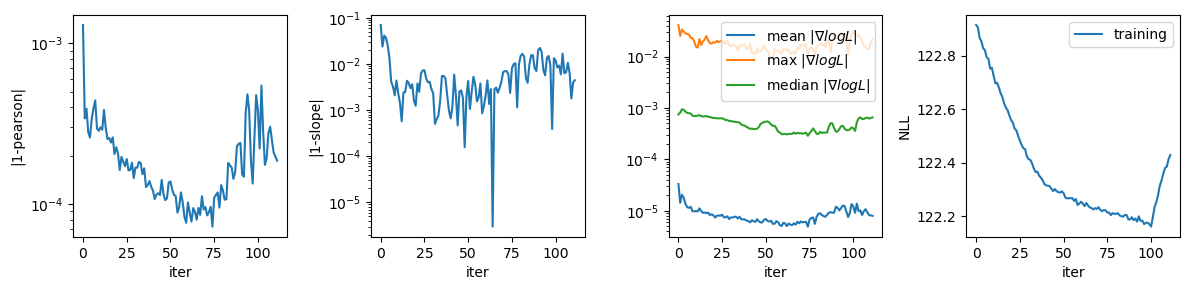

In [135]:
callbacks[0].plot();

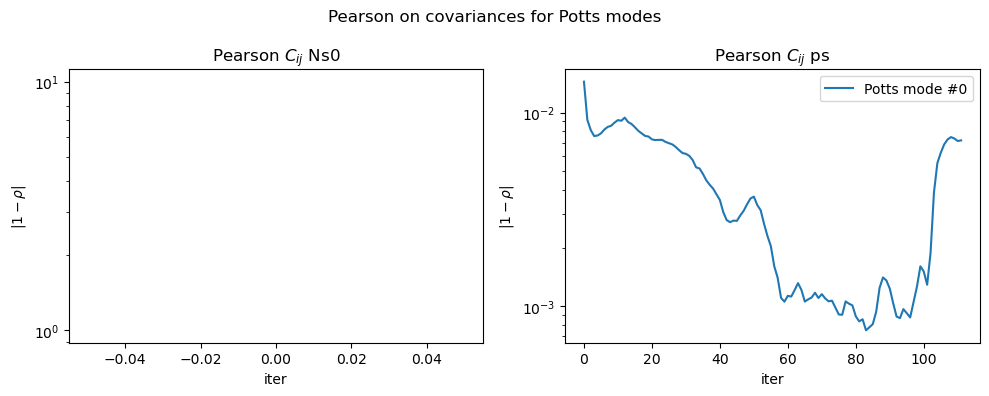

In [136]:
callbacks[1].plot();

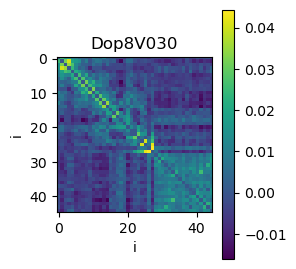

In [137]:
potts_zerosum = model.selection.modes[0].set_zerosum_gauge()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach().cpu())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()

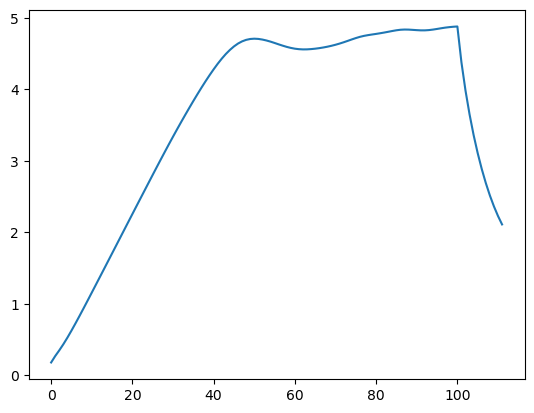

In [138]:
params = list(zip(*callbacks[2].params))
Jnorms = [torch.linalg.norm(J) for J in params[1]]
plt.plot(Jnorms)

In [ ]:
# torch.save(model.cpu(), 'experiments/saved/dataset_1_beads.pt')

Computing mixing time for chains initialized at site frequencies


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …


Computing mixing time for chains initialized uniformly


  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …

  0%|                                                                                                         …


Sampling from the two sets of chains...


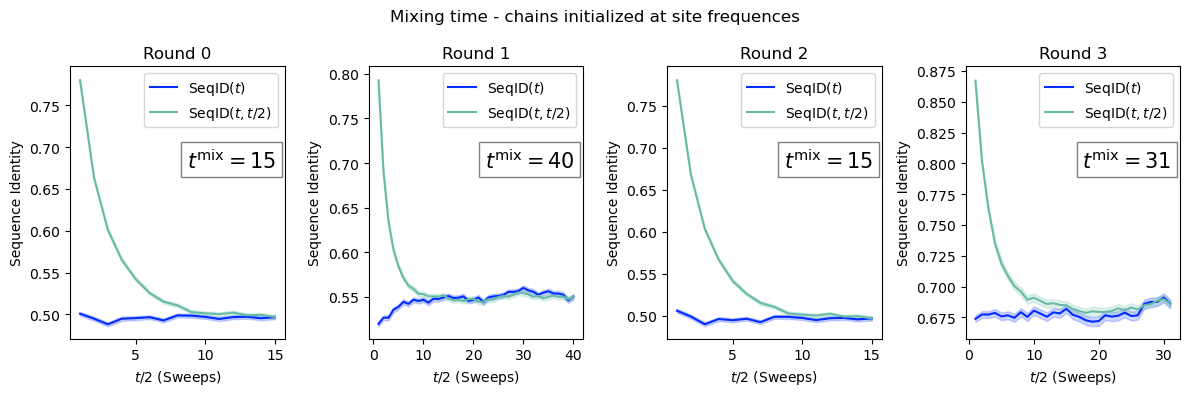

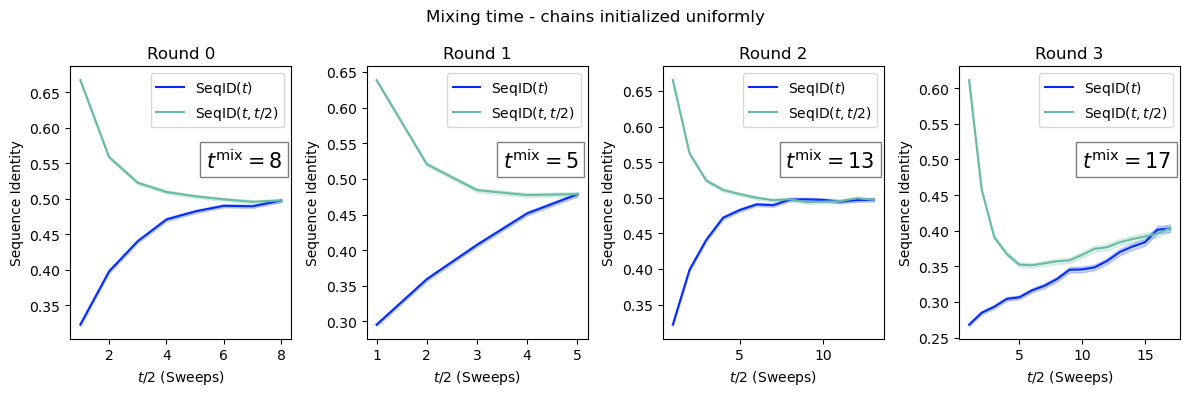

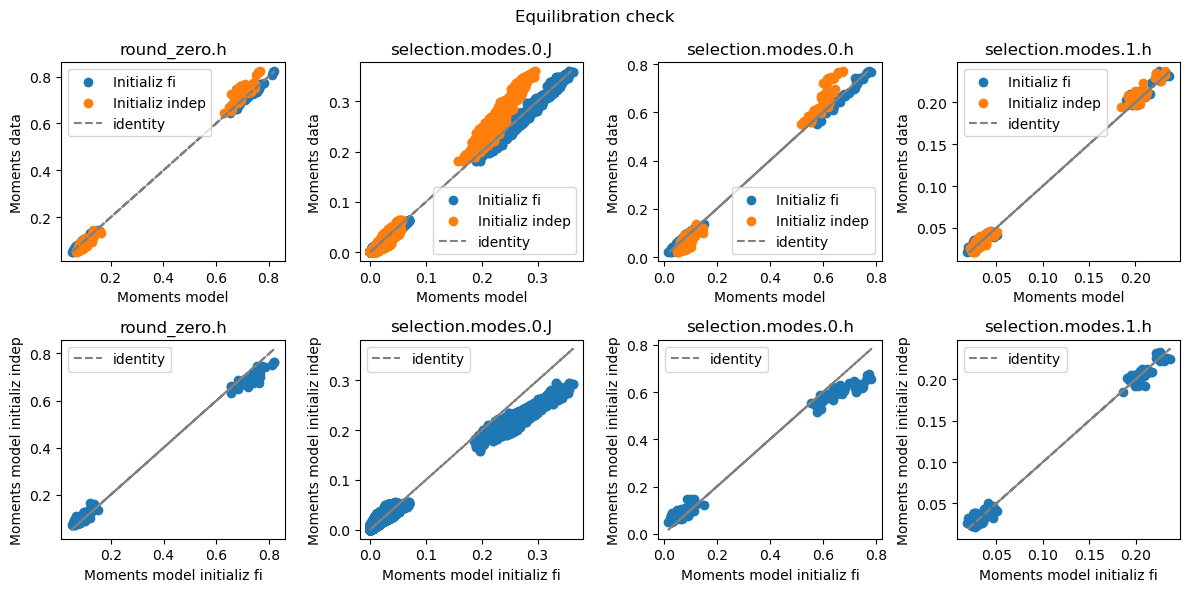

In [132]:
n_chains_equil = 10**3
n_max_sweeps = 10**3

diagnostic.check_equilibration(model, data_loaders, total_reads,
                        n_max_sweeps, n_chains_equil, fi=fi, device=device);

## Same thing but without the info from the control round

In [ ]:
L, q = sequences_oh[0][0].shape
n_rounds_noc = 3

k_noc = k_indep.clone()
h_beads_noc = torch.randn(L, q, dtype=dtype) * 1e-4
h_noc = h_indep.clone()
J_noc = utils.rand_coupling_matrix(L, q, dtype=dtype) * 1e-4

tr_noc = tree.Tree()
tr_noc.add_node(-1)
tr_noc.add_node(0)

selected_modes_noc = torch.BoolTensor(
    [[1, 0],
     [1, 0]]
)

Ns0_noc = energy_models.IndepSites(k_noc)
# indep_noc = energy_models.IndepSites(h_noc)
potts_noc = energy_models.Potts(J_noc, h_noc)
unbound_sel_noc = energy_models.ConstantEnergy(-10)

ps_noc = selex_distribution.MultiModeDistribution(potts_noc, unbound_sel_noc, normalized=True)
model_noc = selex_distribution.MultiRoundDistribution(Ns0_noc, ps_noc, tr_noc, selected_modes_noc).to(device)

Here we only select for unbound and target, and do not use the control round

In [ ]:
total_reads_noc = total_reads[selection_rounds]

In [ ]:
# device = torch.device('cpu')

In [ ]:
batch_size = 10**6
data_loaders_noc = [data_loading.SelexRoundDataLoader(sequences_oh[t], batch_size=batch_size, device=device) for t in selection_rounds]
# n_rounds = len(data_loaders_noc) 

In [ ]:
n_chains = 10**4
chains_noc = training.init_chains(n_rounds_noc, n_chains, L, q, dtype=dtype).to(device)
log_weights_noc = torch.zeros(n_rounds_noc, n_chains, dtype=dtype).to(device)

In [ ]:
callbacks_noc = [callback.ConvergenceMetricsCallback(), callback.PearsonCovarianceCallback(), callback.ParamsCallback(save_every=1)]

In [ ]:
n_sweeps = 10
lr = 0.01
max_epochs = 1000

training.train(model_noc, data_loaders_noc, total_reads_noc, chains_noc, n_sweeps, max_epochs, 
               callbacks=callbacks_noc, log_weights=log_weights_noc, lr=lr)

In [ ]:
callbacks_noc[0].plot();

In [ ]:
callbacks_noc[1].plot();

In [ ]:
potts_zerosum = model_noc.selection.modes[0].set_zerosum_gauge()

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(potts_zerosum.J.detach().cpu())
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
ax.set_title(experiment_id)
plt.colorbar(im)
plt.tight_layout()

In [ ]:
callbacks_noc[2].plot_norm()

In [ ]:
n_chains_equil = 10**3
n_max_sweeps = 10**3

diagnostic.check_equilibration(model_noc, data_loaders_noc, total_reads_noc,
                        n_max_sweeps, n_chains_equil, fi=fi[selection_rounds], device=device);

In [ ]:
# torch.save(model_noc.to(torch.device('cpu')), 'experiments/saved/dataset_1_nobeads.pt')

## Comparison

In [ ]:
model_cpu = model.cpu()
model_noc_cpu = model_noc.cpu()

In [ ]:
N = 10**4
n_sel = model.get_n_rounds()
fig, axes = plt.subplots(1, n_sel, figsize=(12,3))

for t in range(n_sel):
    X = sequences_oh[t]
    x = model_cpu.selection_energy_at_round(X, 1).detach()
    y = model_noc_cpu.selection_energy_at_round(X, 1).detach()
    idx = random.sample(range(len(x)), N)
    ax = axes[t]
    ax.plot(x, x, color='gray')
    ax.scatter(x[idx], y[idx], s=2)
    ax.set_xlabel('logps - beads')
    ax.set_ylabel('logps - no beads')
    ax.set_title(f'Round {round_ids[t]}')
fig.suptitle('log ps')
fig.tight_layout();

In [ ]:
N = 10**4
n_sel = model.get_n_rounds()
fig, axes = plt.subplots(1, n_sel, figsize=(12,3))

for t in range(n_sel):
    X = sequences_oh[t]
    x = - model_cpu.selection.modes[0].compute_energy(X).detach()
    y = - model_noc_cpu.selection.modes[0].compute_energy(X).detach()
    idx = random.sample(range(len(x)), N)
    ax = axes[t]
    ax.plot(x, x, color='gray')
    ax.scatter(x[idx], y[idx], s=2)
    ax.set_xlabel('logps - beads')
    ax.set_ylabel('logps - no beads')
    ax.set_title(f'Round {round_ids[t]}')
fig.suptitle('log ps (target mode)')
fig.tight_layout();

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(10,4))

ax = axes[0]
x = model.round_zero.set_zerosum_gauge().h.detach().cpu()
y = model_noc.round_zero.set_zerosum_gauge().h.detach().cpu()
ax.plot(x, x, color='gray')
ax.scatter(x, y)
ax.set_xlabel('k - beads')
ax.set_ylabel('k - no beads')
ax.set_title('Round zero field k')

ax = axes[1]
x = model.selection.modes[0].set_zerosum_gauge().h.detach().cpu()
y = model_noc.selection.modes[0].set_zerosum_gauge().h.detach().cpu()
ax.plot(x, x, color='gray')
ax.scatter(x, y)
ax.set_xlabel('h - beads')
ax.set_ylabel('h - no beads')
ax.set_title('Selection field h')

ax = axes[2]
x = utils.off_diagonal_terms(model.selection.modes[0].set_zerosum_gauge().J.detach()).cpu()
y = utils.off_diagonal_terms(model_noc.selection.modes[0].set_zerosum_gauge().J.detach()).cpu()
ax.plot(x, x, color='gray')
ax.scatter(x, y)
ax.set_xlabel('J - beads')
ax.set_ylabel('J - no beads')
ax.set_title('Selection couplings J')


fig.tight_layout();

## Load saved models

In [ ]:
# model = torch.load('experiments/saved/dataset_1_beads.pt', weights_only=False)
# model_noc = torch.load('experiments/saved/dataset_1_nobeads.pt', weights_only=False);

In [ ]:
import pickle

filepath = "saved/wildtypes_sites.pkl"

with open(filepath, 'rb') as f:
    wts = pickle.load(f)  

wt = wts[0]
wt_oh = one_hot(wt)

In [ ]:
fig, axes = plt.subplots(1,2)

ax = axes[0]
potts_zerosum = model.selection.modes[0].set_zerosum_gauge()
J = potts_zerosum.J.detach().cpu()
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
# im.set_clim(-0.05, 0.085)
plt.colorbar(im)
ax.set_title('With beads mode')

ax = axes[1]
potts_zerosum = model_noc.selection.modes[0].set_zerosum_gauge()
J = potts_zerosum.J.detach().cpu()
F = selex_dca.get_contact_map(J)
im = ax.imshow(F)
# im.set_clim(-0.05, 0.085)
plt.colorbar(im)
ax.set_title('Without beads mode')

fig.suptitle('Contact map of J')

fig.tight_layout()

In [ ]:
compute_energy_beads = lambda x: model_cpu.selection_energy_at_round(x[None, :, :], 1).detach()
compute_energy_noc = lambda x: model_noc_cpu.selection_energy_at_round(x[None, :, :], 1).detach()
E_beads = utils.epistasis(compute_energy_beads, wt_oh)
E_noc = utils.epistasis(compute_energy_noc, wt_oh)

In [ ]:
fig, axes = plt.subplots(1,2)

ax = axes[0]
im = ax.imshow(selex_dca.get_contact_map(E_beads))
# im.set_clim(-0.05, 0.085)
plt.colorbar(im)
ax.set_title('With beads mode')

ax = axes[1]
im = ax.imshow(selex_dca.get_contact_map(E_noc))
# im.set_clim(-0.05, 0.085)
plt.colorbar(im)
ax.set_title('Without beads mode')

fig.suptitle('Epistasis')

fig.tight_layout()